This file implements Algorithm 1 from the report. We use the MNIST database, along a logistic regression to illustrate the way its limitations.

In [32]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
XX, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')

In [15]:
X_not_normalized = XX.values
X = XX.values
y = y.astype(int).values
X = (X/255. - .5)*2

X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X, y, test_size=0.5)

In [18]:
logistic_clf = LogisticRegression()
logistic_clf.fit(X_train_target, y_train_target)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
#we compute the probability distribution of each pixel.
list_prob = np.zeros((784,256))
for j in tqdm(range(len(X_not_normalized))):
  for i in range(len(X_not_normalized[0])):
    list_prob[i,X_not_normalized[j][i]] += 1


100%|██████████| 70000/70000 [00:55<00:00, 1258.51it/s]


In [26]:
#There are two ways of generating a sample
# - method 1 is totally random
# - method 2 uses the probability distribution of each pixel (that has been computed using the dataset)
def random_from_database1():
  return (np.random.randint(0, 256, 784)/255 -0.5)*2

def random_from_database2():
  res = np.zeros(784)
  for i in range(len(res)):
    res[i] = np.random.choice(np.arange(256), p=list_prob[i]/70000)
  return res


def random_from_database_partial1(y,k):
  indexes = np.random.randint(0, 784, k)
  for index in indexes:
    y[index] = (np.random.randint(0,256)/255 - 0.5)*2
  return y

def random_from_database_partial2(y,k):
  indexes = np.random.randint(0, 784, k)
  for index in indexes:
    y[index] = np.random.choice(np.arange(256), p=list_prob[index]/70000)
  return y

In [27]:
#the algorithm itself
iter_max = 200_000
k_min = 4
rej_max = 10
k_max = 128
list_conf = [0.095*i for i in range(6,11)]
def synthesise_class_c(model,c):
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
  axes = axes.flatten()

  for r in tqdm(range(len(list_conf))):
    conf_min = list_conf[r]

    x = random_from_database2()
    y_c_star = 0
    j = 0
    k = k_max
    done = False
    for i in range(iter_max):
      y = model.predict_proba(x.reshape(1, -1))[0]
      if(y[c] >= y_c_star):
        if(y[c] > conf_min and c == np.argmax(y)):
          if(np.random.rand() < y[c]):
            done = True
            break
        x_star = x
        y_c_star = y[c]
        j = 0
      else:
        j += 1
        if(j > rej_max):
          k = np.max([k_min,int(k/2) +1])
          j = 0
      #we select k parameters that we modifiy
      x = random_from_database_partial2(x_star,k)

    if(done == False):
      x = np.zeros(784)
    axes[r].imshow(x.reshape(28,28),cmap = "Greys")
    axes[r].axis("off")
    axes[r].set_title(r'$conf_{{min}}  = {:.2f}$'.format(round(conf_min,2)))
  plt.tight_layout()
  plt.show()

100%|██████████| 5/5 [00:00<00:00, 24.21it/s]


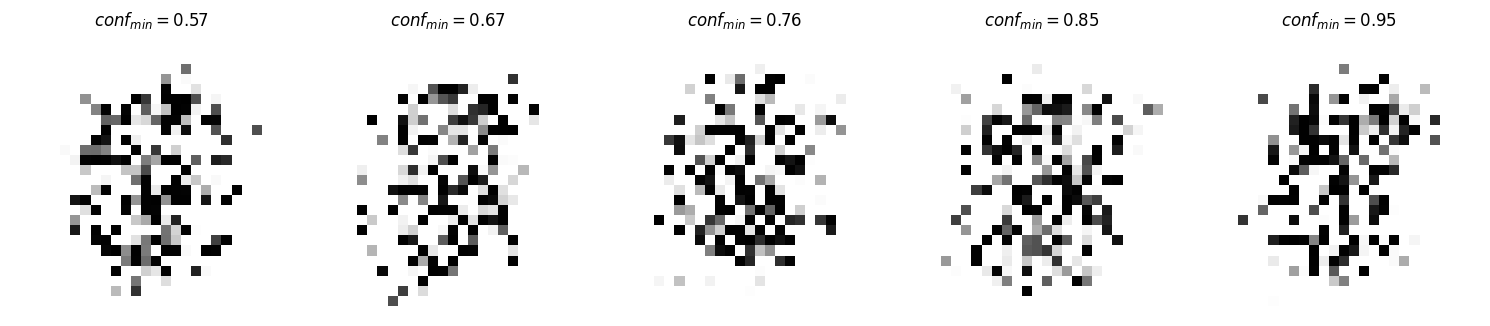

In [33]:
res = synthesise_class_c(logistic_clf,8)